# Tutorial 3: An Introduction to Keras
This tutorial covers 
- [What's Keras?](#sec-1)
- [Example: Regression problem](#sec-2)

## What's Keras? <a class="anchor" id="sec-1"></a>
Keras ([https://keras.io](https://keras.io)) is a deep learning API for Python. It is built on top of Tensorflow ([https://www.tensorflow.org/](https://www.tensorflow.org/)), and its primary purpose is to enable fast experimentation by offering simple workflows. Keras is great for learning and will suffice for many applied deep learning projects.

TensorFlow is one of the most popular and powerful deep learning frameworks, but its use is more complicated when compared to Keras. For ADAMS, simplicity rules and matters more than the greater flexibility Tensorflow or other popular frameworks like [PyTorch](https://pytorch.org/), [MXNet](https://mxnet.apache.org/) have to offer. 

Let's start with Keras. To that end, we will first present the anatomy of Neural Networks from Keras's perspective. Then, we will illustrate its use with a regression example and let you get your hands-on with a multiclass classification exercise. 

### Keras's perspective
In Keras, the main class is the `Layer`. A layer is a module that transforms tensors, like LEGO bricks. The type of the layer depends on the tensor format and the type of data. For example, 
- Rank-2 tensor (samples, features) &rarr; dense layer (`Dense`).
- Rank-3 tensor, such as sequence data, (samples, time, features) &rarr; recurrent layer (`LSTM`, `Conv1D`).
- Rank-4 tensor, e.g. images &rarr; 2D convolution layer (`Conv2D`).

`Layers` are assembled into the `Model` class. A deep learning model is not more than a graph of layers. For example, a model can be a stack of layers mapping a single input to a single output. That corresponds to the subclass of `Model` called `Sequential` in Keras. For example,

```python
model = keras.Sequential([
    layers.Dense(64, activation="relu"),
    layers.Dense(64, activation="relu"),
    layers.Dense(1) # it does not have activation (linear layer by default)
])
```

However, as long as we dive further in the course, we will find other network topologies, including two-branch networks, residual connections, etc. 

Before training your model, you will need to decide
- which `optimizer` (`RMSprop`, `SGD`, etc.) you to use, 
- which `loss` function is adequate for the problem (`MeanSquaredError`, `CategoricalCrossentropy`, etc.), and 
- what `metrics` you want to monitor (`MAE`, `Accuracy`, etc.). 

All three are specified through the `compile()` method. 

Next, you'll use the `fit()` method to train the model. This method implements the loop itself, and its key arguments are the `data`, the number of `epochs`, and the `batch` size. Here we can also monitor the loss and metrics on the `validation` data.

Finally, when the model is trained, we want to use it in new data. To this end, we use the method `predict()` to generate predictions on new data.

## Example: Regression problem <a class="anchor" id="sec-2"></a>
Let's learn how to use Keras with an example. The idea is to predict the median value of owner-occupied homes (in thousands of dollars) in a Boston suburb, given features such as crime rate, the average number of rooms, and so forth. We structure the task in 5 steps:
1. Get the dataset.
2. Prepare the data for the training. Here we transform the data to be suitable for a neural network.
3. Build the model. We create the layers (`Dense` layer), graph (`Sequential` model) and compile the model (`compile()`).
4. Validate the approach. We commonly use training and validation sets to tune our model (`fit()`). Then, retrain the model with the fine-tuned parameters and evaluate the model in the test set.
5. Make predictions on a new dataset. Commonly on the test set (`predict()`).

### 1. Get the dataset
Let's load the data

In [38]:
from tensorflow.keras.datasets import boston_housing
# this will split the data 80-20% by default
(x_train, y_train), (x_test, y_test) = boston_housing.load_data()
# if you want to try out different options, do the following
# import tensorflow as tf
# (x_train, y_train), (x_test, y_test) = tf.keras.datasets.boston_housing.load_data(path="boston_housing.npz", test_split=0.2, seed=113)

In [2]:
# Let's take a look at the shape of the data
print('Shape of train data:',x_train.shape,
'\nShape of test data:', x_test.shape)

Shape of train data: (404, 13) 
Shape of test data: (102, 13)


In [39]:
# Let's take a look at the features
import pandas as pd
pd.DataFrame(x_train).describe()

,0,1,2,3,4,5,6,7,8,9,10,11,12
count,404.000000,404.000000,404.000000,404.000000,404.000000,404.000000,404.000000,404.000000,404.000000,404.000000,404.000000,404.000000,404.000000
mean,3.745111,11.480198,11.104431,0.061881,0.557356,6.267082,69.010644,3.740271,9.440594,405.898515,18.475990,354.783168,12.740817
std,9.240734,23.767711,6.811308,0.241238,0.117293,0.709788,27.940665,2.030215,8.698360,166.374543,2.200382,94.111148,7.254545
min,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,188.000000,12.600000,0.320000,1.730000
25%,0.081437,0.000000,5.130000,0.000000,0.453000,5.874750,45.475000,2.077100,4.000000,279.000000,17.225000,374.672500,6.890000
50%,0.268880,0.000000,9.690000,0.000000,0.538000,6.198500,78.500000,3.142300,5.000000,330.000000,19.100000,391.250000,11.395000
75%,3.674808,12.500000,18.100000,0.000000,0.631000,6.609000,94.100000,5.118000,24.000000,666.000000,20.200000,396.157500,17.092500
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.725000,100.000000,10.710300,24.000000,711.000000,22.000000,396.900000,37.970000


The descriptions of the features are the following (more details about this dataset can be found in [http://lib.stat.cmu.edu/datasets/boston](http://lib.stat.cmu.edu/datasets/boston))
| # | Variable | Description |
|---|---|---|
| 1 | CRIM | per capita crime rate by town |
| 2 | ZN | proportion of residential land zoned for lots over 25,000 sq.ft. |
| 3 | INDUS | proportion of non-retail business acres per town |
| 4 | CHAS | Charles River dummy variable (= 1 if tract bounds river; 0 otherwise) |
| 5 | NOX | nitric oxides concentration (parts per 10 million) |
| 6 | RM | average number of rooms per dwelling |
| 7 | AGE | proportion of owner-occupied units built prior to 1940 |
| 8 | DIS | weighted distances to five Boston employment centres |
| 9 | RAD | index of accessibility to radial highways |
| 10 | TAX | full-value property-tax rate per $10,000 |
| 11 | PTRATIO | pupil-teacher ratio by town |
| 12 | B | 1000(Bk - 0.63)^2 where Bk is the proportion of blacks by town |
| 13 | LSTAT | % lower status of the population |
| 14 | MEDV | Median value of owner-occupied homes in $1000's |

So, we have 404 samples to train and 102 to test, each with 13 numerical features. The target is the median values of homes. Let's have a quick look at them

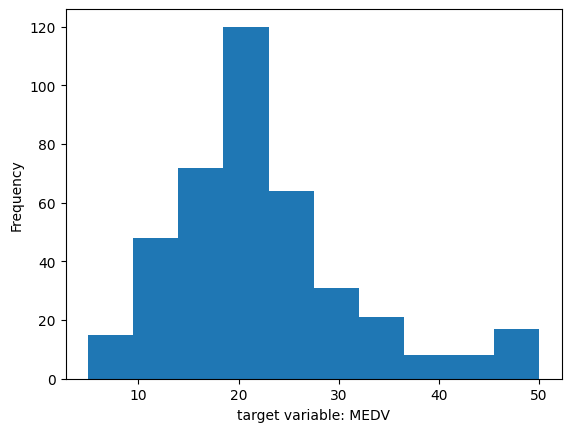

In [41]:
#Plot the values of the target variable: 


import matplotlib.pyplot as plt

plt.hist(y_train)
plt.xlabel('target variable: MEDV')
plt.ylabel('Frequency')
plt.show()


### 2. Data preparation
We saw that `x_train` takes different ranges. This is problematic for neural networks, so a common practice is to standardize each feature.

In [32]:
#Feature rescaling:

from sklearn. preprocessing import StandardScaler
standardscaler = StandardScaler()
x_train_scaled = standardscaler.fit_transform(x_train)


### 3. Building the model
We are ready to build our model. Since the sample size is small, two layers with 64 units will be enough to avoid overfitting. We use ReLU as the non-linearity. 

In [35]:
from tensorflow import keras
from tensorflow.keras import layers
#Build the model:

model = keras.Sequential([
    layers.Dense(64, activation="relu"),
    layers.Dense(64, activation="relu"),
    layers.Dense(1)
])

We compile our model using `Adam` as the optimization algorithm. Of course, there are many other alternatives for the `optimizer`, such as `SGD`, `Adagrad`, `Adadelta`, etc. (see [https://keras.io/api/optimizers/](https://keras.io/api/optimizers/)).

We use the Mean Square Error as the loss (`mse`) (see [https://keras.io/api/losses/](https://keras.io/api/losses/) for other alternatives). We also track the Mean Absolute Error (`mae`) defined in `metrics`. 

In [37]:
#compile the model:

model.compile(optimizer='Adam',
              loss='mse',
              metrics='mae')

### 4. Validate the approach
In this step, we fit the model. To do it, we first create a validation set from the train data.

In [3]:
#Split into train and validation set:

from sklearn.model_selection import train_test_split

For the training we will use 100 epochs and a batch size of 16

In [4]:
# Fit the model:

model.fit(x_train_scaled, y_train, validation_split=0.33, epochs=100, batch_size=16)

Let's plot the training and validation loss

In [5]:
#Plot the training and the validation loss using the training history from the fitted model:



In [6]:
#Build the model again:
#compile it, train it and test it:

### 5. Generate predictions on new data
The function `predict()` returns the predicted median price of the houses (in $1,000).

In [7]:
#Generate predictions and plot them: